In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from discretize import TensorMesh
from SimPEG import simulation, maps
import pymc as pm

# plt.rcParams['figure.figsize'] = [8.0, 8.0]
plt.rcParams['figure.dpi'] = 150

ModuleNotFoundError: No module named 'pymc'

# Bayesian Inverse Theory / Markhov chain Monte carlo (MCMC)

## Bayes' Theorem

Question, what is the probability of event $A$ given event $B$?

\begin{equation}
P(A | B) = \frac{P(B | A) P(A)}{P(B)}
\end{equation}

* $P(A | B)$, $P(B|A)$ are conditional probabilities (also called posterior probabilities)


Used to answer questions like: 
* If a patient has symptoms of a disease, what is the likelyhood they have that disease?
* Or (for geophysics) given I have collected a set of data, what is the likelyhood of a model?

## For example:
Question: If I have a cough, what is the probability I have COVID-19?

* $A$ : COVID positive?
* $B$ : Coughing?

Then what are the probabilities in Bayes' theorem asking?

* $P(A)$ What is the probability a random person has COVID?
* $P(B|A)$ What is the probability a person with COVID has a cough?
* $P(B)$ What is the probability a random person has a cough?

## Continuous distributions
More relevant to geophysics where we have continuous distributions:

\begin{equation}
P(x | y) = \frac{ P( y | x) P (x)}{P(y)}
\end{equation}

* $P(x)$ is our prior probability distribution on model parameters
* $P(y|x)$ the conditional probability of data given a model

The denominator is often hard to determine (but is always a positive constant) as it involves integrating over all possible $x$, so we often say:

\begin{equation}
P(x | y ) \propto P(y | x) P(x)
\end{equation}


## Connection to deterministic inversion

---
**Recall**
The probability density function (PDF) of a normal distribution with mean $\mu$ and standard deviation $\sigma$, notated as $N(\mu,\sigma^2)$ is defined as:

\begin{equation}
P(x) = \frac{1}{\sqrt{2\pi}\sigma} \exp \left(-\frac{1}{2} (\frac{\mu - x}{\sigma})^2\right)
\end{equation}

The multivariate form of this equation is:

\begin{equation}
P(x) = \sqrt{\frac{|\mathbf{T}|}{(2\pi)^k}} \exp \left(-\frac{1}{2} (\mu - x)^T \mathbf{T} (\mu - x)\right)
\end{equation}

* Where $\mathbf{T}$ is the precission matrix (thought of as $Cov^{-1}$ when covariance matrix is invertible)

---

Deterministic inversion is used to answer the question: What is the most likely model, given the observed data?

Assume a simple Linear forward system (i.e. gravity)

\begin{equation}
G m = d
\end{equation}

Then we measure some data that is contamintated by noise from a normal distribution with a known standard deviation.

\begin{equation}
d_{i} = d_{i,true} + \epsilon_i \hspace{10pt} \epsilon_i \sim N(0, \sigma^2)
\end{equation}

Then the conditional probability (or likelyhood) of the data, given a model $m$ is:

\begin{equation}
P(d | m ) \propto \exp \left(\frac{-1}{2 \sigma^2}(d - G m)^T(d - G m)\right)
\end{equation}

* The model vector undergoes a linear transformation
* The mean of this distribution is our data $d$
* The standard deviation is the same as the distribution of the error

Now we make the assumption that our model parameters also follow a normal distribution, $N(0, \gamma^2$):

\begin{equation}
P(m) \propto \exp \left( \frac{-1}{2 \gamma^2}m^Tm\right)
\end{equation}

## Posterior distribution

The posterior distribution is then:

\begin{align}
P(m | d) &\propto \exp \left(\frac{-1}{2 \sigma^2}(d - G m)^T(d - G m)\right) \exp \left(\frac{-1}{2 \gamma^2}m^Tm\right)\\
         &\propto \exp \left(\frac{-1}{2} (\frac{1}{\sigma^2}(d - G m)^T(d - G m) + \frac{1}{\gamma^2}m^Tm\right)
\end{align}

Now what is the most likely model? (Maximize the posterior!)
* When is the gaussian maximized?

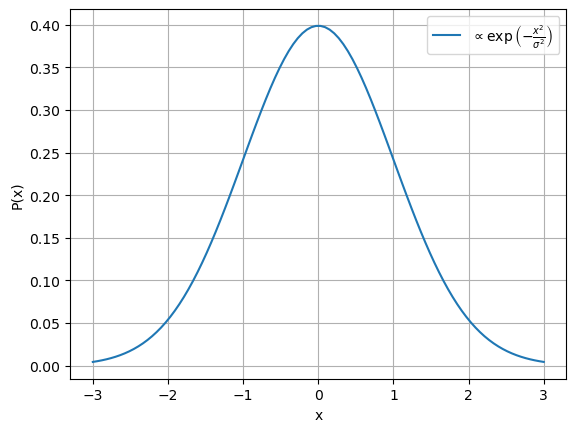

In [4]:
x = np.linspace(-3, 3, 100);
plt.plot(x, stats.norm.pdf(x, 0, 1), label=r"$\propto \exp \left(-\frac{x^2}{\sigma^2}\right)$")
plt.xlabel('x'); plt.ylabel('P(x)'); plt.legend(); plt.grid()

## Maximum a posteriori probability (MAP)
So find when argument is minimized

\begin{equation}
\min_m \hspace{5pt} \frac{1}{\sigma^2}(d - G m)^T(d - G m) + \frac{1}{\gamma^2}m^Tm
\end{equation}

* Hey that's what we solve for deterministic inversion!
* Take a derivative, set it equal to 0, and solve for $m$
* Observe the connection between regularization parameter and the standard deviation of the model prior distribution

# A deterministic inversion:

In [5]:
nParam = 100  # Number of model paramters

# A 1D mesh is used to define the row-space of the linear operator.
mesh = TensorMesh([nParam])

# Creating the true model
true_model = np.zeros(mesh.nC)
true_model[mesh.vectorCCx > 0.3] = 1.0
true_model[mesh.vectorCCx > 0.45] = -0.5
true_model[mesh.vectorCCx > 0.6] = 0

c:\Users\johnk\Anaconda3\envs\jresearch\lib\site-packages\discretize\utils\code_utils.py:182: FutureWarning: TensorMesh.vectorCCx has been deprecated, please use TensorMesh.cell_centers_x. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)


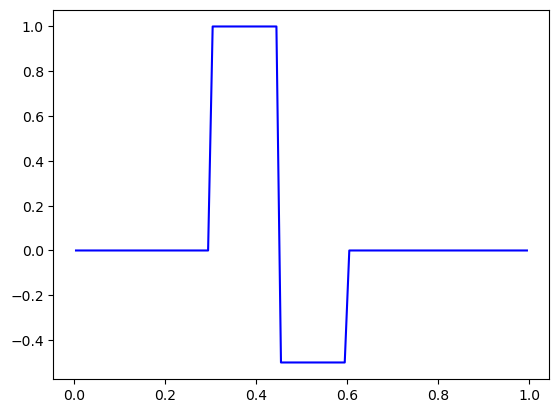

In [6]:
# Plotting the true model
plt.plot(mesh.vectorCCx, true_model, "b-")

In [7]:
# Number of data observations (rows)
nData = 20

# Create the linear operator for the tutorial.
# The columns of the linear operator represents a set of decaying and oscillating functions.
sim = simulation.ExponentialSinusoidSimulation(
    model_map=maps.IdentityMap(), mesh=mesh, n_kernels=nData, p=-0.25, q=0.25, j0=1, jn=60
)
G = sim.G

In [124]:
# Standard deviation of Gaussian noise being added
data_std = 0.001
np.random.seed(3211)

# Create a SimPEG data object
data_obj = sim.make_synthetic_data(true_model, noise_floor=data_std, add_noise=True)

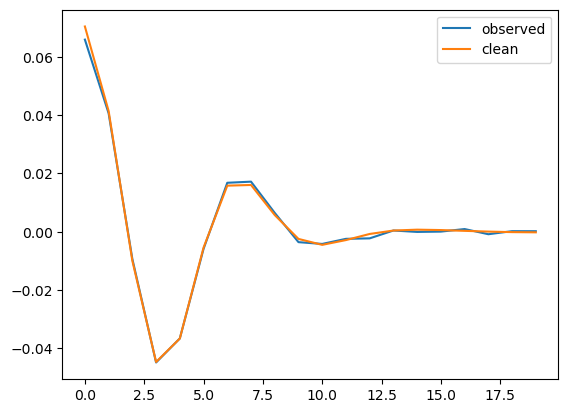

In [9]:
plt.plot(data_obj.dobs, label='observed')
plt.plot(data_obj.dclean, label='clean')
plt.legend();

* Now lets assume the model has a standard deviation of 0.5, and a mean of 0
* We want to do this:
\begin{equation}
\min_m \hspace{5pt} \frac{1}{\sigma^2}(d - G m)^T(d - G m) + \frac{1}{\gamma^2}m^Tm
\end{equation}

take a derivative, set equal to zero...

\begin{align}
-2 G^T \frac{1}{\sigma^2}(d-Gm) + 2\frac{1}{\gamma^2}m &=0 \\
\frac{1}{\sigma^2} G^T G m + \frac{1}{\gamma^2} m &= \frac{1}{\sigma^2} G^T d
\end{align}

In [8]:
model_std = 0.4
Wd = np.diag(1/data_obj.standard_deviation)

A = G.T @ Wd.T @ Wd @ G + 1/model_std**2 * np.eye(G.shape[1])
b = G.T @ Wd.T @ Wd @ data_obj.dobs

m_max_post = np.linalg.solve(A, b)

In [9]:
del_d = Wd @ (G @ m_max_post - data_obj.dobs)
print(del_d.T @ del_d)

17.952558562596035


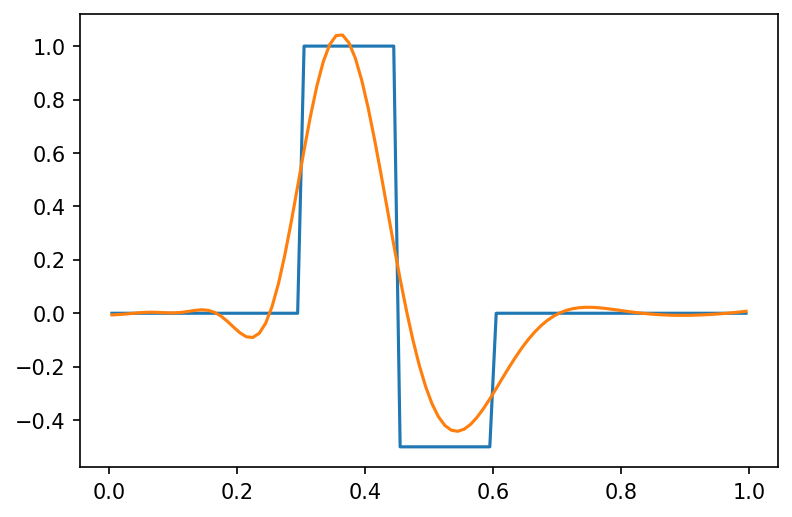

In [10]:
plt.plot(mesh.vectorCCx, true_model)
plt.plot(mesh.vectorCCx, m_max_post)

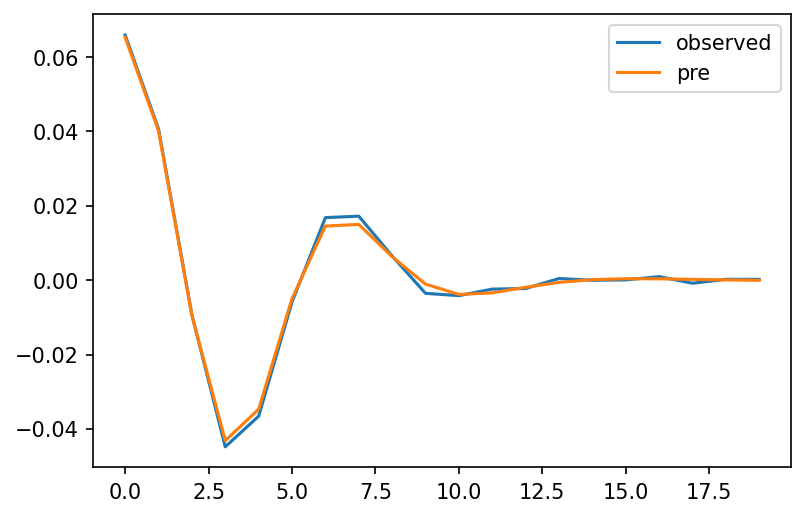

In [11]:
plt.plot(data_obj.dobs, label='observed')
plt.plot(G @ m_max_post, label='pre')
plt.legend();

## A few more things

Model smoothness implies a correlation between model parameters,

\begin{equation}
P(m) \propto \exp \left({-\frac{1}{2} (m - m_{ref})^T W_m^TW_m (m - m_{ref})^T}\right)
\end{equation}

* $\mathbf{T}=W_m^T W_m$
* reference model is the mean of the distribution

$\ell_1$ norms imply a different prior distribution on model parameters, specifically a Laplace$(\mu, b)$ distribution.

\begin{equation}
P(x) = \frac {1}{2b}\exp \left(-{\frac {|x-\mu |}{b}}\right)
\end{equation}

## So why/why not?

* Posterior distribution gives us access to information about the model and its distribution
* Even in cases of a simple linear system, generating draws (models) from the posterior distribution is not necessarily straightforward

# Sampling Distributions

## Sampling a distribution
* Question: How do you generate random samples from a distribution?

Let's define an arbitrary distribution, say a triangular distribution defined between $a$ and $b$ with a maximum point at $c$
\begin{equation}
P_{tri}(x)= \begin{cases}
    0 & \text{for } x < a, \\
    \frac{2(x-a)}{(b-a)(c-a)} & \text{for } a \le x < c, \\[4pt]
    \frac{2}{b-a}             & \text{for } x = c, \\[4pt]
    \frac{2(b-x)}{(b-a)(b-c)} & \text{for } c < x \le b, \\[4pt]
    0 & \text{for } b < x.
 \end{cases}
\end{equation}
**Note** this is carefully defined such that it integrates to 1

In [12]:
def p_tri(x, a, b, c):
    if x < a: return 0
    elif x < c: return 2*(x-a)/(b-a)/(c-a)
    elif x == c: return 2*(b-a)
    elif x <= b: return 2*(b-x)/(b-a)/(b-c)
    else: return 0
a, b, c = -0.8, 0.5, 0.0
xs = np.linspace(-1, 1, 256)
pdf = np.array([p_tri(x, a, b, c) for x in xs])

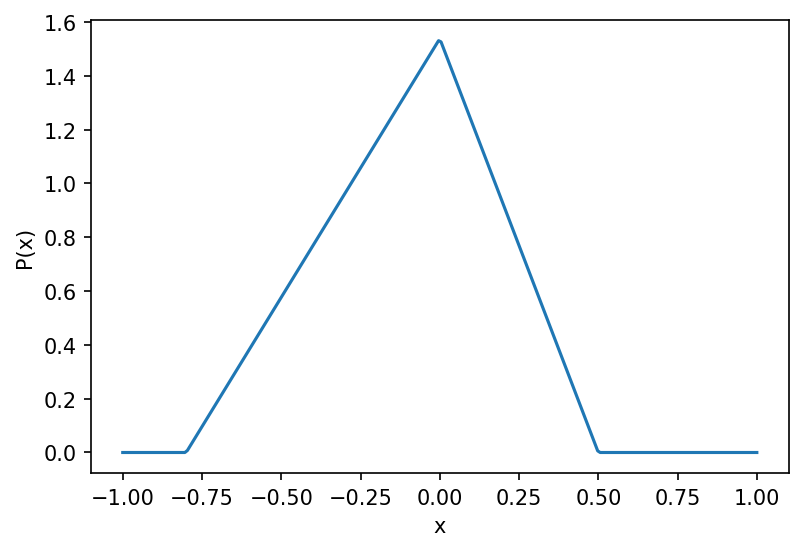

In [13]:
plt.plot(xs, pdf)
plt.xlabel('x'); plt.ylabel('P(x)');

It has a cumulative distribution function,

\begin{equation}
  CDF_{tri}(x) = \begin{cases}
    0 & \text{for } x \leq a, \\
    \frac{(x-a)^2}{(b-a)(c-a)} & \text{for } a < x \leq c, \\
    1-\frac{(b-x)^2}{(b-a)(b-c)} & \text{for } c < x < b, \\
    1 & \text{for } b \leq x.
  \end{cases}
\end{equation}
---------
**Note**
\begin{equation}
CDF(x) = \int_{-\infty}^{x} PDF(x) dx
\end{equation}

---------

In [14]:
def cdf_tri(x, a, b, c):
    if x <= a: return 0
    elif x <= c: return (x-a)**2/(b-a)/(c-a)
    elif x < b: return 1 - (b-x)**2/(b-a)/(b-c)
    else: return 1

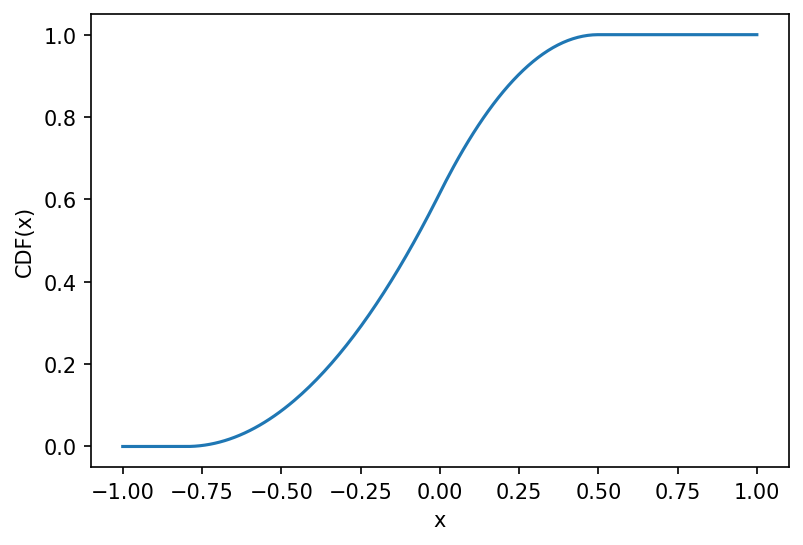

In [15]:
cd = np.array([cdf_tri(x, a, b, c) for x in xs])
plt.plot(xs, cd); plt.xlabel('x'); plt.ylabel('CDF(x)');

## Drawing samples from this distribution

Very simple approach
* make a random draw between 0 and 1
* solve the cdf for x


Inverse of the simple triangular CDF function given by,

In [16]:
def cdf_inv(y, a, b, c):
    if y == 1: return b
    elif y > (c-a)/(b-a): return b - np.sqrt((1 - y)*(b-a)*(b-c))
    elif y > 0: return np.sqrt(y*(b-a)*(c-a)) + a
    else: return a

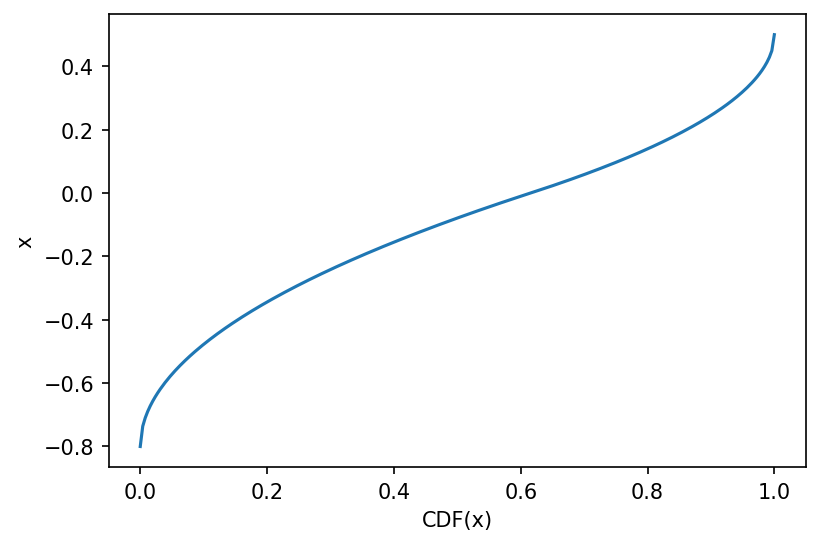

In [17]:
y = np.linspace(0, 1, 256)
cdi = np.array([cdf_inv(y, a, b, c) for y in y])
plt.plot(y, cdi); plt.xlabel('CDF(x)'); plt.ylabel('x')

Make random draws from a uniform distribution,

In [18]:
ys = np.random.rand(10000)
draws = [cdf_inv(y, a, b, c) for y in y]

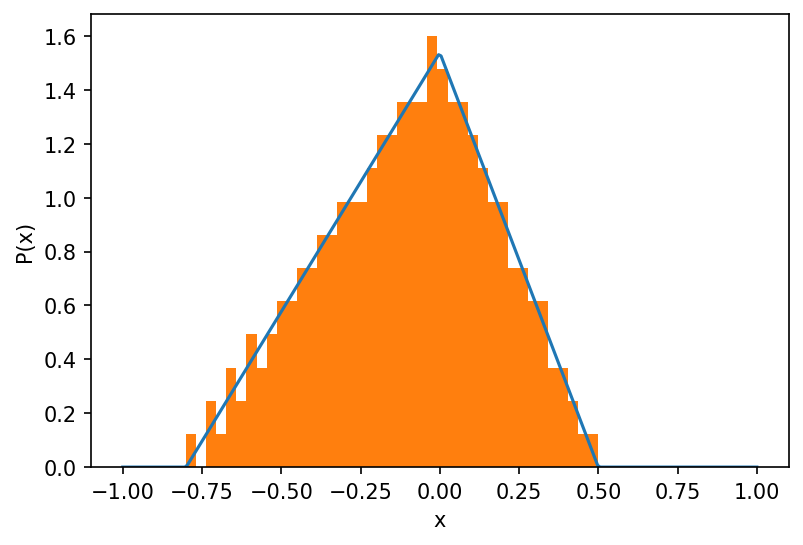

In [19]:
plt.plot(xs, pdf)
plt.hist(draws, bins=41, density=True);
plt.xlabel('x'); plt.ylabel('P(x)');

## What if I only know the numerator?

for our posterior distribution for inversion, we said:
\begin{equation}
P(x|y) \propto P(y|x) P(x)
\end{equation}
* $P(y)$ often difficult to calculate
* No hope of finding a CDF or inverting it to use the above method to calculate draws from the distribution

Let's try to define another distribution, that is an addition of two "simple" distributions:

\begin{equation}
P_{harder}(x) = \frac{P_{Tri}(x) + P_{N(0, 0.4)}(x)}{C} = \frac{f(x)}{C}
\end{equation}

\begin{equation}
C = \int_{-\infty}^{\infty} f(x) dx
\end{equation}

* what does this look like?

In [20]:
def f_harder(x):
    return p_tri(x, a, b, c) + stats.norm.pdf(x, 0, 0.4)

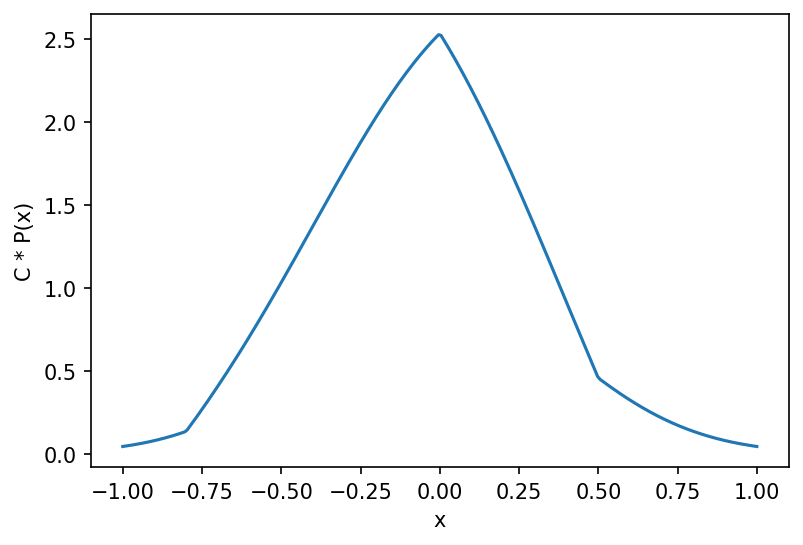

In [21]:
pdf = np.array([f_harder(x) for x in xs])
plt.plot(xs, pdf)
plt.xlabel('x'); plt.ylabel('C * P(x)');

## Accept/Reject sampling
* Choose a function that is easy to generate samples from
* Hopefully it is close to the given function
* Must be always larger than our given function

Start with a Guassian, $g(x)$

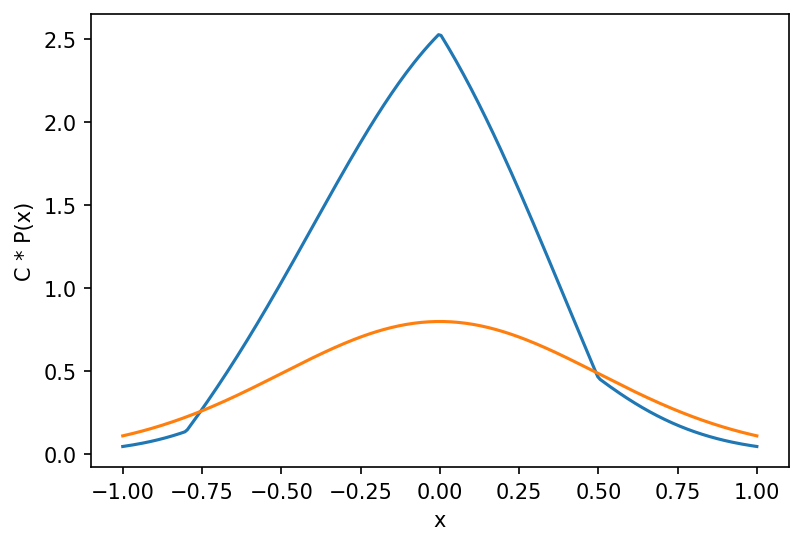

In [22]:
pdf = [f_harder(x) for x in xs]
g_x = [stats.norm.pdf(x, 0, 0.5) for x in xs]
plt.plot(xs, pdf); plt.plot(xs, g_x); plt.xlabel('x'); plt.ylabel('C * P(x)');

 Scale it to be larger than our given distribution on its domain, $Mg(x)$

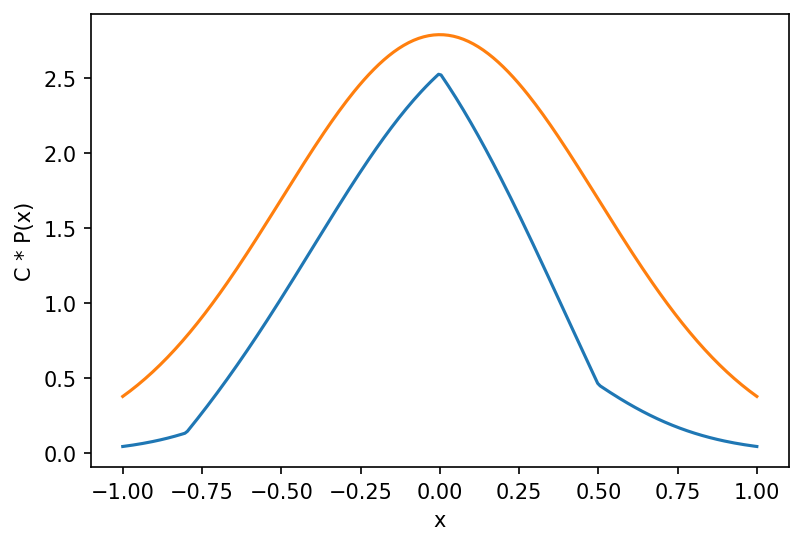

In [23]:
pdf = [f_harder(x) for x in xs]
g_x = [3.5*stats.norm.pdf(x, 0, 0.5) for x in xs]
plt.plot(xs, pdf); plt.plot(xs, g_x); plt.xlabel('x'); plt.ylabel('C * P(x)');

Accept reject sample has two simple steps,

1. Make a random draw from $g(x)$ (the simple distribution)
2. Accept the sample with a probability of 
\begin{equation}
\frac{f(x)}{M g(x)}
\end{equation}

In [24]:
n_samples = 10000
n_accept = 0
gx_dist = stats.norm(0, 0.5)
samples = []
while n_accept < n_samples:
    test = gx_dist.rvs()
    ratio = f_harder(test)/(3.5 * gx_dist.pdf(test))
    accepted = np.random.rand(1) <= ratio
    if accepted:
        samples.append(test)
    n_accept += 1

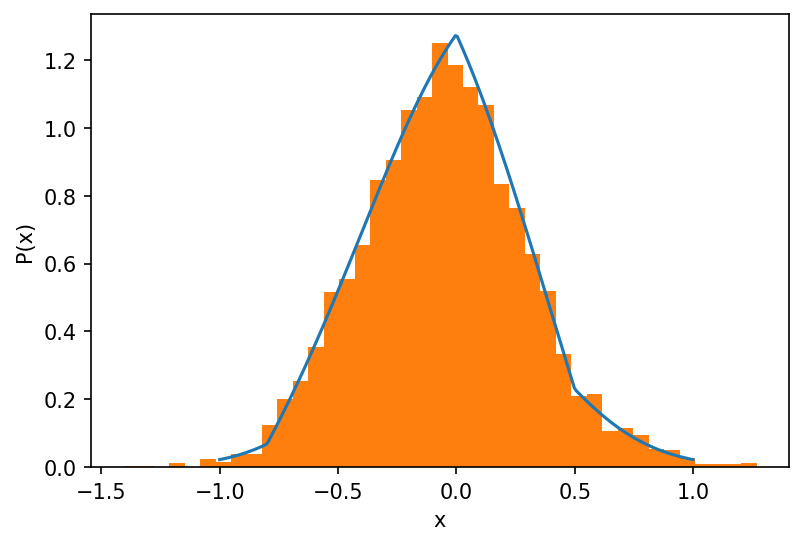

In [25]:
plt.plot(xs, pdf/(np.sum(pdf)*(xs[1]-xs[0])));
plt.hist(samples, bins=41, density=True); plt.xlabel('x'); plt.ylabel('P(x)');

## Why does this work?

What is the probability density of a sample, given we have accepted it? (aka how often does a given sample get accepted?)

Go back to Bayes' Theorem

\begin{equation}
P(s | A) = \frac{P(A | s) P(s)}{P(A)}
\end{equation}

Probability of accepting any given sample is:
\begin{equation}
P(A | s) = \frac{f(s)}{M g(s)}
\end{equation}

The probability of a sample is:
\begin{equation}
P(s) = g(s)
\end{equation}

### Probability of accepting?

Can just integrate the numerator over all samples!

\begin{align}
P(A) &= \int_{-\infty}^{\infty} \frac{f(s)}{M g(s)} g(s) ds\\
    &= \frac{1}{M}\int_{-\infty}^{\infty} f(s)ds\\
    &= \frac{C}{M}
\end{align}

All together:

\begin{align}
P(s|A) &= \frac{\frac{f(s)}{M g(s)} g(s)}{ \frac{C}{ M}}\\
&= \frac{f(s)}{C} \\
&= P_{harder}(x)
\end{align}

## So... why does it work?

* Think about the probability of accepting a sample
    * If high probability, that means f(x) high, g(x) low
    * We are more likely to accept a sample if it is rarely generated by our easily sample distribution and it is reltively likely in the target distribution

## Pros
* Independant identically distributed samples (iid)
* Robust

## Cons

* Can be slow
* does not scale well to high dimensions
* Very reliant on g(x) and the scaling parameter
    * The less your easy function g(x) looks like your target, the longer it takes
    * The larger M, the less likely you are to accept a sample -> longer

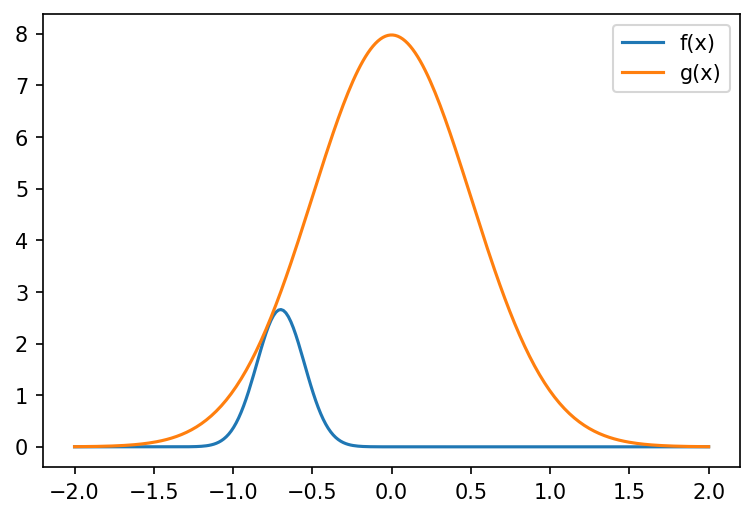

In [26]:
vs = np.linspace(-2,2,256)
plt.plot(vs, stats.norm.pdf(vs, -0.70, 0.15), label='f(x)')
plt.plot(vs, 10*stats.norm.pdf(vs, 0, 0.5), label='g(x)')
plt.legend();

## How can we improve this?
What if we used previous accepted samples to inform our future samples?

# Markhov chain Monte Carlo (MCMC)

# A simple idea

Let's make the next draw dependant on the previous!

<img src="markhov_chain.png" alt="drawing" width="400"/>

This is a Markhov chain!

* The real challenge comes in designing how to transition from one sample to the next

## Goal: 

The stationary distribution of the Markhov chain should be the target distribution $P(x)$

* given enough samples, the steady-state simulates draws from the distribution

 <img src="eventual_chain.png" alt="drawing" width="400"/>
* Throw out the first N "Burn-in" samples

* Schemes are designed with specfic transition propabilities

\begin{equation}
T(x_{i+1} | x_{i})
\end{equation}

* for MCMC to work a scheme must satisfy something called the "Detailed Balance"

\begin{equation}
P(x) T(y|x) = P(y)T(x|y) \hspace{5pt} \forall x,y
\end{equation}

### What is important about "Detailed Balance" condition?
* Steady state of a Markhov chain means that the probability distribution of subsequent samples does not change
* For MCMC, the steady state distribution should be our target distribution
    * Tells us how to design our transition probabilities


Why does this work?

Let's integrate the Detailed Balance over all x...

\begin{align}
P(x) T(y|x) &= P(y)T(x|y)\\
\int_x P(x) T(y|x) dx &= \int_x P(y)T(x|y) dx\\
 &= P(y) \int_x T(x|y) dx \\
 &= P(y)
\end{align}

What does that mean?
* The probability of obtaining $y$ from any $x$ is equal to the target probability densitiy of $y$

* in discrete probability, think of a state of probabilities $p$ being a left eigenvector of the system $pT=p$, where $T$ is the transition probability matrix

## MCMC methods
* Random Walk
    * Metropolis-Hastings
    * Gibbs sampling
* Hamiltonian

## Metropolis-Hastings

Use the current sample to select the next sample (MCMC)

* Metropolis-Hastings says that we create a candidate distribution that is dependant on the current sample.

\begin{equation}
g(x | y)
\end{equation}

Take a sample from the candidate distribution, $x$, with what probability should we accept it $A(x, y)$?
* Our transition probability is then the probability we propose a sample times the probabilty we accept that sample.

\begin{equation}
T(x|y) = g(x | y) A(x, y)
\end{equation}

* We either accept the new proposal, or keep the current state and move forward

* Look at the detailed balance condition

\begin{align}
p(x) T(y|x) &= p(y) T(x|y)\\
p(x) g(y|x) A(y, x) &= p(y) g(x|y) A(x, y)\\
\frac{A(y, x)}{A(x, y)} &= \frac{p(y)}{p(x)} \frac{g(x|y)}{g(y|x)}\\
\frac{A(y, x)}{A(x, y)} &= \frac{f(y)}{f(x)} \frac{g(x|y)}{g(y|x)} \\
\frac{A(y, x)}{A(x, y)} &= r_f r_g
\end{align}

Metropolis-Hastings separates this into two cases to propose acceptance probabilities:

\begin{equation}
r_f r_g >= 1
\end{equation}

which implies

\begin{align}
A(y, x) &= 1\\
A(x, y) &= \frac{1}{r_f r_g}
\end{align}

and

\begin{equation}
r_f r_g < 1
\end{equation}

implying acceptance probabilities of

\begin{align}
A(y, x) &= r_f r_g\\
A(x, y) &= 1
\end{align}

Together, these two imply an acceptance probability of

\begin{equation}
A(y, x) = \min(1, r_fr_g)
\end{equation}

* if you plug both cases into the detailed balance condition, you will see it satisfied

* This implies a correlation between samples, no longer independant
* Less dependant on candidate distribution (no scaling factor)
* Metropolis-Hastings algorithm independant of candidate distribution
* Metropolis is a special case considering a symmetric candidate distribution, $g(x|y) = g(y|x)$

# Let's code it!

Lets use a symmetric $g(x|y)$ taken as $N(x_{i-1}, 0.3)$

In [27]:
def met_hastings(func, n_samples, x0, std=1, sym=True):
    samples = [x0,]

    gx = stats.multivariate_normal(samples[-1], cov=std**2)
    fx = func(samples[-1])
    n_accept = 0
    for i in range(n_samples):
        # generate sample from a candidate distribution
        x_test = gx.rvs()

        fxp1 = func(x_test)
        rf = fxp1/fx

        if not sym:
            gxp1 = stats.norm(x_test, 0.3)
            rg = gxp1.pdf(samples[-1]) / gx.pdf(x_test)
        else:
            rg = 1 # in this case because the candidate distribution is symmetric

        if np.random.random() < min(1, rf*rg):
            n_accept += 1
            samples.append(x_test)
            if sym:
                gx = stats.multivariate_normal(samples[-1], cov=1)
            else:
                gx = gxp1
            fx = fxp1
        else:
            samples.append(samples[-1])
    samples = np.array(samples)
    return samples, n_accept

In [28]:
samples, n_accept = met_hastings(f_harder, n_samples=10000, x0=-5)
print(n_accept)

3801


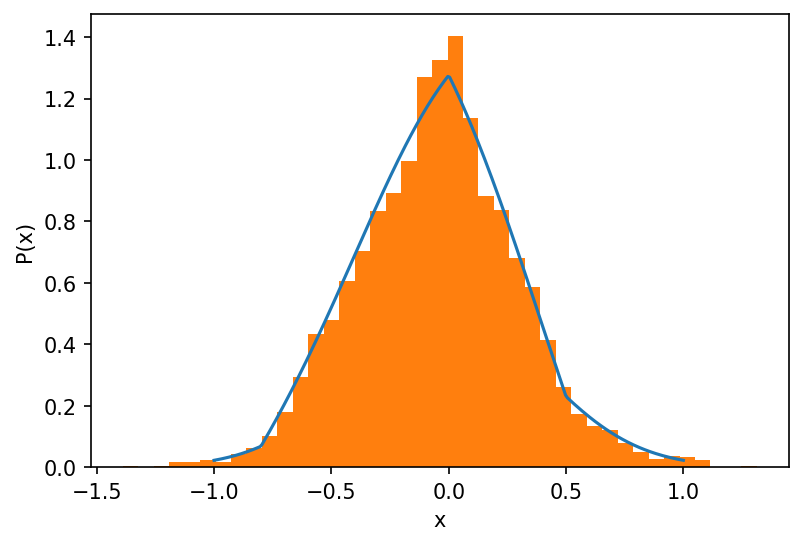

In [29]:
plt.plot(xs, pdf/(np.sum(pdf)*(xs[1]-xs[0])));
plt.hist(samples[20:], bins=41, density=True); plt.xlabel('x'); plt.ylabel('P(x)');

In [30]:
samples[:20]

array([-5.        , -4.79987265, -4.79987265, -4.79987265, -3.99968377,
       -3.99968377, -3.99968377, -3.75608578, -3.75608578, -3.75608578,
       -3.75608578, -1.87613245, -0.38065898,  0.22762575,  0.22762575,
        0.13367792,  0.0568876 ,  0.0568876 ,  0.0568876 , -0.28813446])

### How does this extend to higher dimensions?
* Start with 2D
* Then apply it to our Linear Problem

In [31]:
def f_test(x):
    x, y = x
    return np.exp(-(x**2 - 2*x*y + y**2)-np.abs(x)-np.abs(y))

samples, n_accept = met_hastings(f_test, n_samples=10000, x0=np.random.randn(2))
print(n_accept)

3523


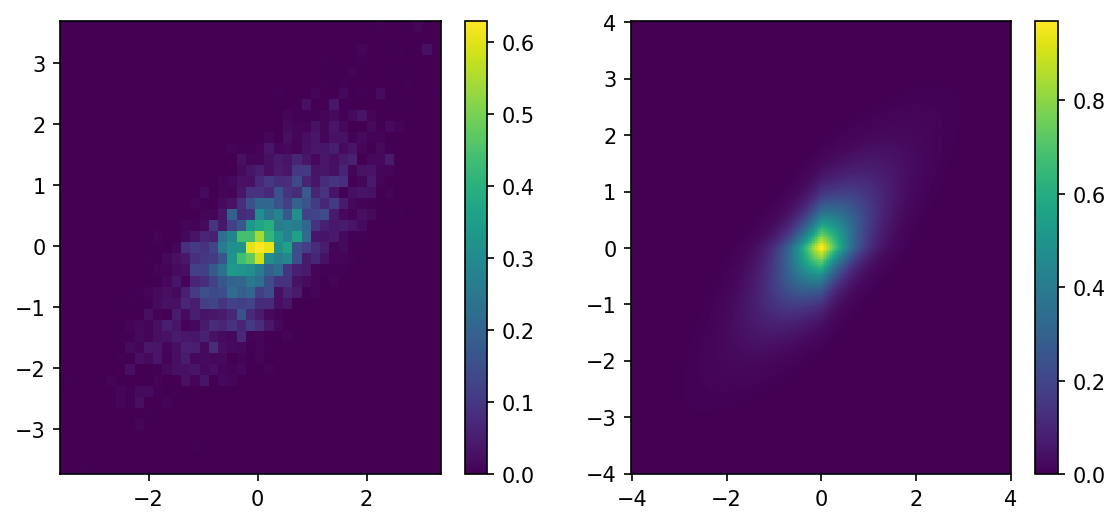

In [32]:
plt.figure(figsize=(9, 4))
plt.subplot(121)
plt.hist2d(samples[:, 0], samples[:, 1], density=True, bins=41);
plt.colorbar()

plt.subplot(122)
xx, yy = np.mgrid[-4:4:256j,-4:4:256j]
plt.pcolormesh(xx, yy, f_test((xx,yy)))
plt.colorbar()

What about our linear inversion?

In [33]:
def f_test(x):
    del_d = Wd @ (G @ x - data_obj.dobs)
    f_log = del_d.T @ del_d + 1/model_std**2 * (x.T @ x)
    return np.exp(-f_log/2)

samples, n_accept = met_hastings(f_test, n_samples=10000, x0=m_max_post)
print(n_accept)

0


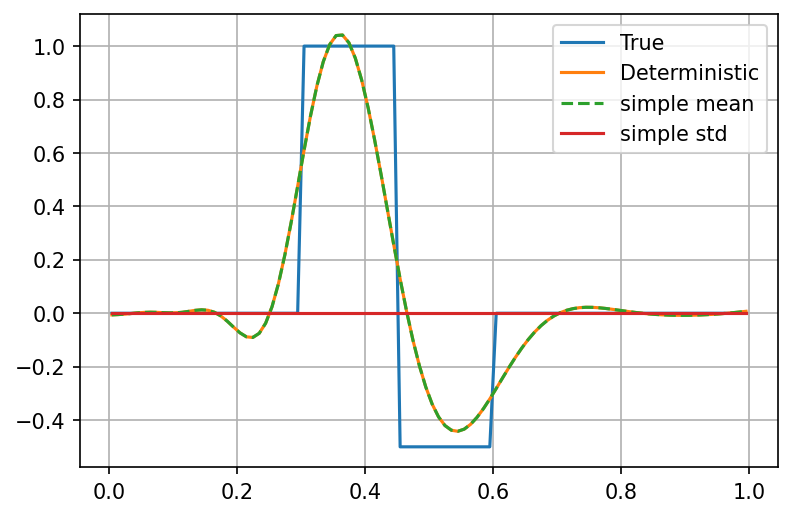

In [34]:
plt.plot(mesh.vectorCCx, true_model, label='True')
plt.plot(mesh.vectorCCx, m_max_post, label='Deterministic')
plt.plot(mesh.vectorCCx, samples.mean(axis=(0)), '--',label='simple mean')
plt.plot(mesh.vectorCCx, samples.std(axis=(0)), label='simple std')
plt.legend(); plt.grid()

Well, that didn't work very well.

* Classic Metropolis-Hastings also does not scale well to higher dimensions....
* As we increase the dimensionality, the mean step length scales by $\sqrt{N}$
    * Step size increases
    * Larger steps likely lead to low probability areas

# Hamiltonian MCMC

Idea:

Let's inform the next candidate based on the gradient of the distribution at the current sample.

### Hamiltonian equations:

\begin{align}
\frac{\text{d}x_{i}}{\text{d}t}&=\frac{\partial H}{\partial p_{i}}\\
\frac{\text{d}p_{i}}{\text{d}t}&=-\frac{\partial H}{\partial x_{i}}
\end{align}

* The Hamiltonian is akin to the total energy of the system.

What do solutions to these equations look like?

* Imagine, holding a ball on a string, and throwing it. These equations describe the motion of the ball.
* As the ball moves, it's energy changes between kinetic and potential energy and it oscillates back and forth.

### in MCMC...
\begin{equation}
{\displaystyle H(\mathbf {x} ,\mathbf {p} )=U(\mathbf {x} )+{\dfrac {1}{2}}\mathbf {p} ^{\text{T}}M^{-1}\mathbf {p} }
\end{equation}
* Define the potential energy as the negative log of our target distribution, $ U(\mathbf{x}) = -log(f(\mathbf{x}))$ 
    * For us this is our objective function!
* Starting at a sample point, give the sample a random "kick" (draw a momentum vector from a $N(0, M)$
distribution)
* Model it's movement according to Hamiltonian dynamics
    * Solve the above PDE's (usually by a leap frog method)
* Determine an acceptance criterion to fit into the Metropolis-Hastings algorithm

### Leap frog steps:
repeat L times:

\begin{align}
p_n(t + \frac{\Delta t}{2}) &= p_n(t) - \frac{\Delta t}{2} \nabla U(x_n(t))\\
x_n(t + \Delta t) &= x_n(t) + \Delta t M^{-1} p_n(t+\frac{\Delta t}{2})\\
p_n(t + \Delta t) &= p_n(t + \frac{\Delta t}{2}) - \frac{\Delta t}{2} \nabla U(x_n(t + \Delta t))\\
\end{align}

Accept with a probability of...

\begin{equation}
\alpha (x_0, x_1) = \min(1, \frac{f(x_n(t+L\Delta t)}{f(x_n(t))} \frac{g(p_n(t+L\Delta t))}{g(p_n(t))})
\end{equation}

* $f(x)$ is our target distribution
* $g(x)$ is our momentum distribution

## The Meat

In [35]:
def hmc(neg_log_func, d_neg_log_func, n_samples, x0, n_leap_frog=4 ,step_size=0.25, p_std=1):

    samples = [x0, ]
    M = np.diag(p_std**2 * np.ones_like(x0))
    momentum_dist = stats.multivariate_normal(mean=np.zeros_like(x0), cov=M)
    M_inv = 1/p_std**2 * np.ones_like(x0)
    
    n_accept = 0 
    deriv = d_neg_log_func(samples[0])
    x0_nlp = neg_log_func(samples[0])
    for i in range(n_samples):
        x0 = samples[-1]
        x1 = x0.copy()
        
        p0 = momentum_dist.rvs()
        p1 = p0.copy()

        # leapfrog integration begin
        deriv = d_neg_log_func(x1)
        for s in range(n_leap_frog):
            p1 -= step_size * deriv/2
            x1 += step_size * M_inv * p1
            deriv = d_neg_log_func(x1)
            p1 -= step_size * deriv/2
        # leapfrog integration end
        p1 *= -1
        # reverse momentum at the final location for reversibility
        # In this case the momentum distribution is symmetric, so it doesn't matter...

        #metropolis acceptance
        x1_nlp = neg_log_func(x1)
        
        p0_nlp = -momentum_dist.logpdf(p0)
        p1_nlp = -momentum_dist.logpdf(p1)
        
        # Account for negatives AND log(probabiltiies)...
        target = x0_nlp - x1_nlp # f(x1)/f(x0)
        adjustment = p0_nlp - p1_nlp # g(p1)/g(p0)
        acceptance = target + adjustment # rf * rg
        
        if np.log(np.random.random()) <= acceptance:
            samples.append(x1)
            x0_nlp = x1_nlp
            n_accept += 1
        else:
            samples.append(x0)

    return np.array(samples), n_accept

* Does it work for my 2D example?

In [36]:
def f_test(x):
    x, y = x
    return np.exp(-(x**2 - 2*x*y + y**2)-np.abs(x)-np.abs(y))

def neg_log_f_test(x):
    x, y = x
    return x**2 - 2*x*y + y**2 + np.abs(x) + np.abs(y)

def deriv_neg_log_f_test(x):
    x, y = x
    return np.r_[2*x - 2*y + np.sign(x), -2*x + 2*y + np.sign(y)]

In [37]:
samples, n_accept = hmc(
    neg_log_f_test, deriv_neg_log_f_test, n_samples=20000, x0=[0, 0], n_leap_frog=5 ,step_size=0.1
)
print(n_accept)

19655


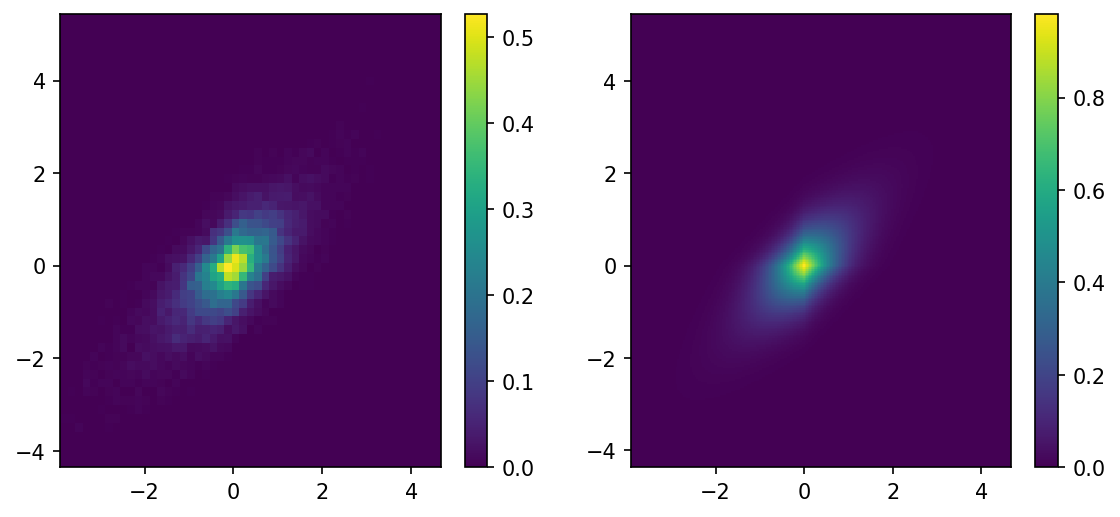

In [38]:
plt.figure(figsize=(9, 4))
plt.subplot(121)
x_samp, y_samp = samples[100:, ].T
plt.hist2d(x_samp, y_samp, density=True, bins=51);
plt.colorbar()

plt.subplot(122)
xx, yy = np.mgrid[x_samp.min():x_samp.max():256j,y_samp.min():y_samp.max():256j]
plt.pcolormesh(xx, yy, f_test((xx,yy)))
plt.colorbar();

* And the 1D inversion???

In [39]:
def f_test(x):
    del_d = Wd @ (G @ x - data_obj.dobs)
    f_log = del_d.T @ del_d + 1/model_std**2 * (x.T @ x)
    return np.exp(-f_log/2)

def neg_log_f_test(x):
    del_d = Wd @ (G @ x - data_obj.dobs)
    return (del_d.T @ del_d + 1/model_std**2 * (x.T @ x))/2

def deriv_neg_log_f_test(x):
    del_d = Wd @ (G @ x - data_obj.dobs)
    return G.T @ (Wd.T @ del_d) + 1/model_std**2 * x

In [40]:
samples, n_accept = hmc(neg_log_f_test, deriv_neg_log_f_test, n_samples=20000, 
                        x0=np.random.randn(nParam), n_leap_frog=15, step_size=0.03)
print(n_accept);

13978


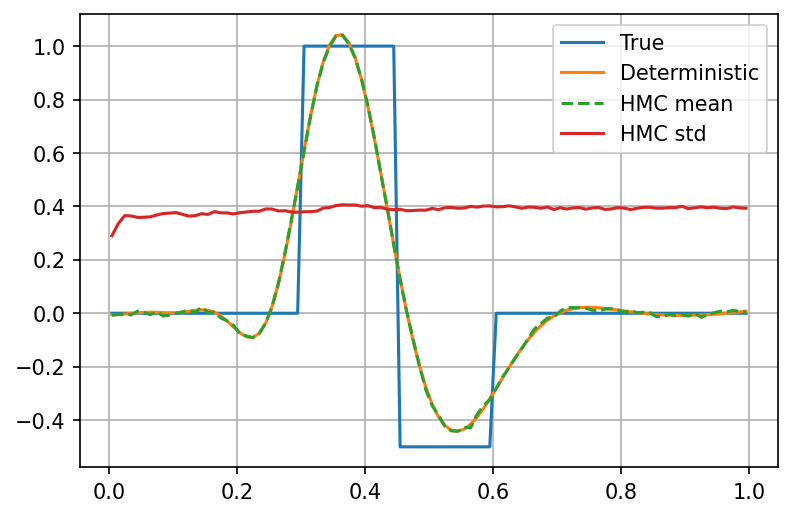

In [41]:
plt.plot(mesh.vectorCCx, true_model, label='True')
plt.plot(mesh.vectorCCx, m_max_post, label='Deterministic')
plt.plot(mesh.vectorCCx, samples[100:].mean(axis=(0)), '--',label='HMC mean')
plt.plot(mesh.vectorCCx, samples[100:].std(axis=(0)), label='HMC std')
plt.legend(); plt.grid()

* Not bad!

However, it is very dependant on the choice of step length, and the number of steps
* More sophisticated techniques of automatically choosing these parameters exist
* No U-Turn Sampling (NUTS)

# pymc

Here is an example implementation in python that makes use of NUTS to perform Hamiltonian MCMC

In [ ]:
with pm.Model() as model:  # model specifications in PyMC are wrapped in a with-statement
    # Define priors
    model_prior = pm.Normal("Model Prior", mu=0, sigma=model_std, shape=nParam)

    # Define likelihood
    likelihood = pm.Normal("y", mu=G @ model_prior, sigma=data_obj.standard_deviation, observed=data_obj.dobs)

    # Inference!
    # draw 8000 posterior samples using NUTS sampling
    idata = pm.sample(8000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/Users/josephcapriotti/opt/anaconda3/envs/mcmc_tutorial/lib/python3.8/site-packages/pymc/model.py:984: FutureWarning: `Model.initial_point` has been deprecated. Use `Model.recompute_initial_point(seed=None)`.
  warnings.warn(
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Model Prior]
/Users/josephcapriotti/opt/anaconda3/envs/mcmc_tutorial/lib/python3.8/site-packages/pymc/model.py:984: FutureWarning: `Model.initial_point` has been deprecated. Use `Model.recompute_initial_point(seed=None)`.
  warnings.warn(


In [ ]:
draws = idata.posterior['Model Prior']

In [ ]:
plt.plot(mesh.vectorCCx, true_model, label='True')
plt.plot(mesh.vectorCCx, m_max_post, label='Deterministic')
plt.plot(mesh.vectorCCx, draws.mean(axis=(0, 1)), '--',label='MCMC mean')
plt.plot(mesh.vectorCCx, draws.std(axis=(0, 1)), label='MCMC std')
plt.legend(); plt.grid()

Next I've plotted the Histogram of the sampled models at each spatial location

This can give an idea of the shape of the distribution for the recovered models.

In [ ]:
plt.hist2d(np.tile(np.arange(100)/100, 4*8000), np.array(draws).reshape(-1),bins=100);
plt.plot(mesh.vectorCCx, draws.mean(axis=(0, 1)), '--',label='MCMC mean')

But what does a random draw from this distribution look like?

In [ ]:
plt.plot(mesh.vectorCCx, true_model, label='True')
plt.plot(mesh.vectorCCx, m_max_post, label='Deterministic')
plt.plot(mesh.vectorCCx, draws[0, 3229], '--',label='A draw')
plt.legend(); plt.grid()

In [36]:
import numpy as np
from scipy.stats import multivariate_normal

def gaussian_pdf(x, mean, covariance):
    """
    Calculates the Gaussian probability density function (PDF).

    Args:
        x (numpy.ndarray): Input vector.
        mean (numpy.ndarray): Mean vector.
        covariance (numpy.ndarray): Covariance matrix.

    Returns:
        float: The probability density at point x.
    """
    distribution = multivariate_normal(mean, covariance)
    return distribution.pdf(x)

# Example usage:
mean = data_obj.dobs
covariance = data_obj.standard_deviation
xs = np.arange(-10, 11)

pdf_value = [gaussian_pdf(x, mean, covariance) for x in xs]
# pdf_value = gaussian_pdf(x, mean, covariance)
print("PDF value:", pdf_value)

PDF value: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.446797596752203e+20, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


0.000528736199672022


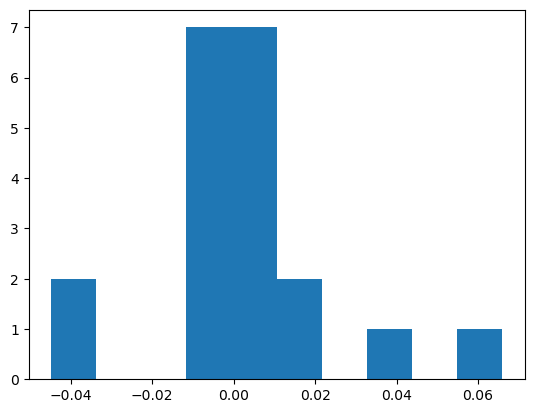

In [42]:
# plt.plot(xs, pdf_value)
from scipy import stats
plt.hist(data_obj.dobs)

print(np.cov(data_obj.dobs))

## This works

c:\Users\johnk\Anaconda3\envs\jresearch\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


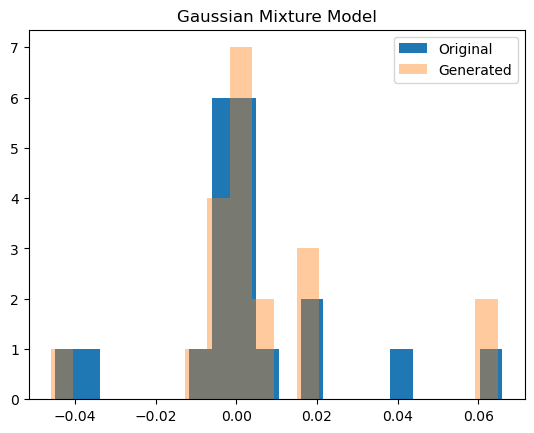

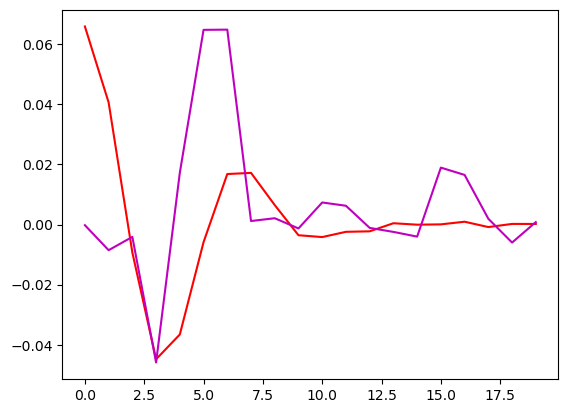

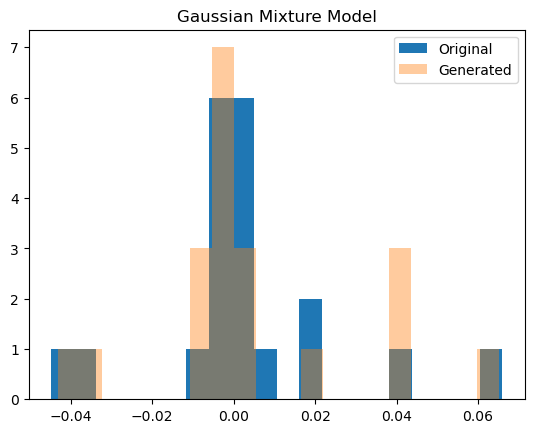

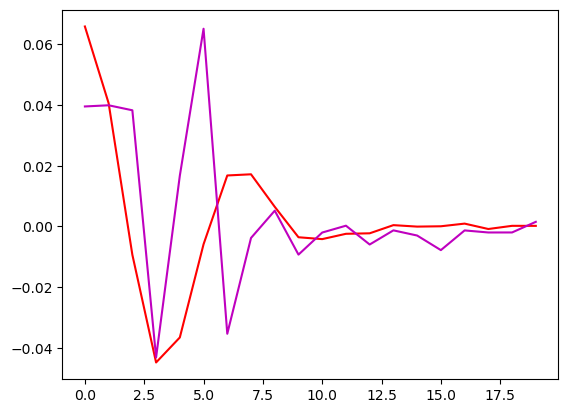

In [134]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

# Generate sample data
np.random.seed(0)
n_samples = 1000
n_components = 20

# Generate two Gaussian distributions
X = data_obj.dobs.reshape(-1, 1)

# Fit Gaussian mixture model
gmm = GaussianMixture(n_components=n_components)
gmm.fit(X)

# gmm.means_ = data_obj.dobs
# gmm.covariances_ = data_obj.standard_deviation**2

for ii in range(2):

    # Generate new samples from the fitted model
    X_new, _ = gmm.sample(n_samples=20)

    # Plot the original and generated samples
    plt.hist(X, 20, label='Original')
    plt.hist(X_new, 20, label='Generated', alpha=0.4)
    plt.legend()
    plt.title('Gaussian Mixture Model')
    plt.show()
    plt.plot(X, 'r')
    plt.plot(X_new, 'm')
    plt.show()




1.0 1


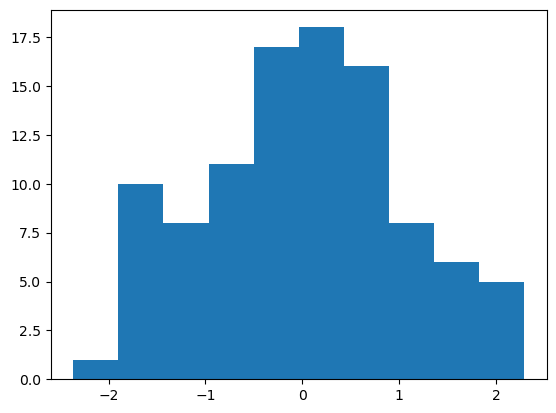

c:\Users\johnk\Anaconda3\envs\jresearch\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


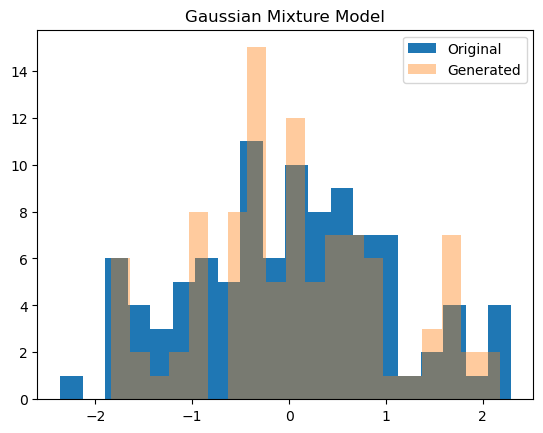

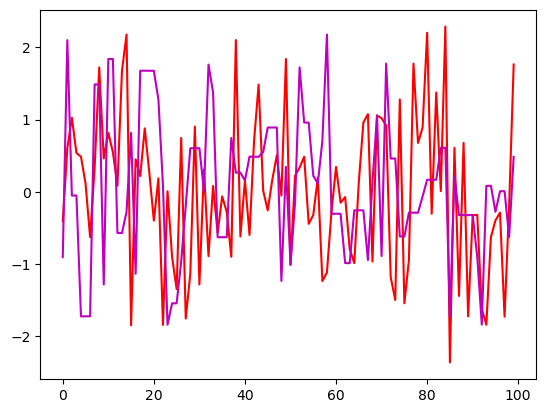

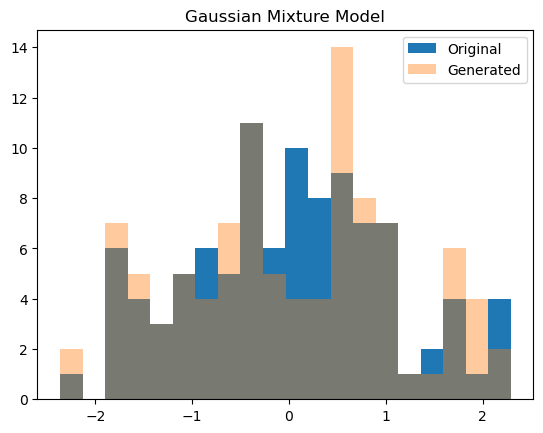

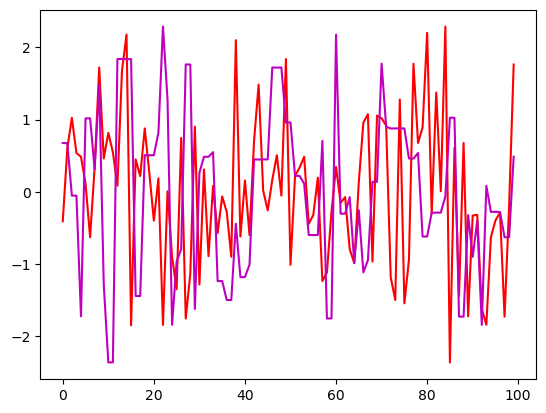

In [144]:
mean = 0.0
mu = 1 #np.mean(data_obj.dobs)

sigma = 1 / np.sqrt(mu)
print(sigma, mu)

s = np.random.normal(mean, sigma, 100)

plt.hist(s)
plt.show()

n_components = 100

# Generate two Gaussian distributions
X = s.reshape(-1, 1)

# Fit Gaussian mixture model
gmm = GaussianMixture(n_components=n_components)
gmm.fit(X)

# gmm.means_ = data_obj.dobs
# gmm.covariances_ = data_obj.standard_deviation**2

for ii in range(2):

    # Generate new samples from the fitted model
    X_new, _ = gmm.sample(n_samples=100)

    # Plot the original and generated samples
    plt.hist(X, 20, label='Original')
    plt.hist(X_new, 20, label='Generated', alpha=0.4)
    plt.legend()
    plt.title('Gaussian Mixture Model')
    plt.show()
    plt.plot(X, 'r')
    plt.plot(X_new, 'm')
    plt.show()

## End of what works

In [105]:
np.mean(true_model)

0.075

(20, 1)


c:\Users\johnk\Anaconda3\envs\jresearch\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


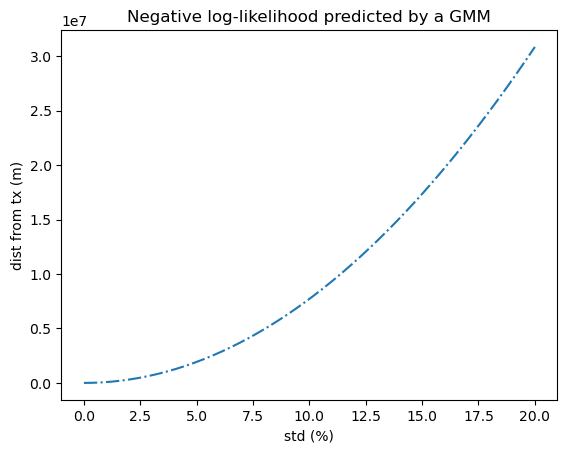